# Anime Recommedation Project

In [368]:
#Importing all the libraries I'll be using for this notebook

import pandas as pd
pd.set_option('display.max_columns',50)
import re
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset
from surprise.model_selection import cross_validate, train_test_split
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline, SVD, SVDpp
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from IPython.display import clear_output

### Data Cleanup

In [2]:
#Importing dataset of all anime titles  into a Dataframe
anime_df_no_syn = pd.read_csv('./Anime_data/anime.csv')

In [3]:
anime_df_no_syn.head(5)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,Bandai Visual,"Funimation, Bandai Entertainment",Sunrise,Original,24 min. per ep.,R - 17+ (violence & profanity),28.0,39,1251960,61971,105808,718161,71513,26678,329800,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,"Sunrise, Bandai Visual",Sony Pictures Entertainment,Bones,Original,1 hr. 55 min.,R - 17+ (violence & profanity),159.0,518,273145,1174,4143,208333,1935,770,57964,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,Victor Entertainment,"Funimation, Geneon Entertainment USA",Madhouse,Manga,24 min. per ep.,PG-13 - Teens 13 or older,266.0,201,558913,12944,29113,343492,25465,13925,146918,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,"TV Tokyo, Bandai Visual, Dentsu, Victor Entert...","Funimation, Bandai Entertainment",Sunrise,Original,25 min. per ep.,PG-13 - Teens 13 or older,2481.0,1467,94683,587,4300,46165,5121,5378,33719,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,"TV Tokyo, Dentsu",Unknown,Toei Animation,Manga,23 min. per ep.,PG - Children,3710.0,4369,13224,18,642,7314,766,1108,3394,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
#Checking for any null values
anime_df_no_syn.isna().sum()

MAL_ID           0
Name             0
Score            0
Genres           0
English name     0
Japanese name    0
Type             0
Episodes         0
Aired            0
Premiered        0
Producers        0
Licensors        0
Studios          0
Source           0
Duration         0
Rating           0
Ranked           0
Popularity       0
Members          0
Favorites        0
Watching         0
Completed        0
On-Hold          0
Dropped          0
Plan to Watch    0
Score-10         0
Score-9          0
Score-8          0
Score-7          0
Score-6          0
Score-5          0
Score-4          0
Score-3          0
Score-2          0
Score-1          0
dtype: int64

In [5]:
#Checking the DTypes of all columns in the dataframe
anime_df_no_syn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [6]:
#Checking for any extreme values
anime_df_no_syn.describe()

,MAL_ID,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,1.756200e+04,17562.000000,17562.000000,17562.000000
mean,21477.192347,8763.452340,3.465854e+04,457.746270,2231.487758,2.209557e+04,955.049653,1176.599533,8199.831227
std,14900.093170,5059.327278,1.252821e+05,4063.473313,14046.688133,9.100919e+04,4275.675096,4740.348653,23777.691963
min,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,1.000000
25%,5953.500000,4383.500000,3.360000e+02,0.000000,13.000000,1.110000e+02,6.000000,37.000000,112.000000
50%,22820.000000,8762.500000,2.065000e+03,3.000000,73.000000,8.175000e+02,45.000000,77.000000,752.500000
75%,35624.750000,13145.000000,1.322325e+04,31.000000,522.000000,6.478000e+03,291.750000,271.000000,4135.500000
max,48492.000000,17565.000000,2.589552e+06,183914.000000,887333.000000,2.182587e+06,187919.000000,174710.000000,425531.000000


### Creating a column for Cleaned names

To have a name for every show in the dataframe, I created a new column called Cleaned_Name, using a list comprehension, to iterate through the English name column and use the english name unless the name is 'Unknown", then it uses the 

In [8]:
anime_df_no_syn['Cleaned_Name'] = [anime_df_no_syn['English name'][x] if anime_df_no_syn['English name'][x] != 'Unknown' 
                else (anime_df_no_syn['Name'][x] if anime_df_no_syn['Name'][x] != 'Unknown'
                else anime_df_no_syn['Japanese name']) for x in range(len(anime_df_no_syn['English name']))]

In [9]:
anime_df_no_syn[['Name', 'English name', 'Japanese name', 'Cleaned_Name']].head()

,Name,English name,Japanese name,Cleaned_Name
0,Cowboy Bebop,Cowboy Bebop,カウボーイビバップ,Cowboy Bebop
1,Cowboy Bebop: Tengoku no Tobira,Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Cowboy Bebop:The Movie
2,Trigun,Trigun,トライガン,Trigun
3,Witch Hunter Robin,Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),Witch Hunter Robin
4,Bouken Ou Beet,Beet the Vandel Buster,冒険王ビィト,Beet the Vandel Buster


### Changing Aired column to Datetime

In [10]:
anime_df_no_syn['Aired'][0][7:11]

'1998'

In [11]:
pattern = '\d{4}'
re.findall(pattern, anime_df_no_syn['Aired'][0])

['1998', '1999']

In [12]:
anime_df_no_syn['Year_Premiered'] = [re.findall(pattern, anime_df_no_syn['Aired'][x]) for x in range(len(anime_df_no_syn['Aired']))]




In [13]:
anime_df_no_syn['Year_Premiered'] = [['Unknown'] if len(anime_df_no_syn['Year_Premiered'][x]) == 0
                                     else anime_df_no_syn['Year_Premiered'][x]
                                     for x in range(len(anime_df_no_syn['Year_Premiered']))]

In [14]:
anime_df_no_syn['Year_Premiered'] = [anime_df_no_syn['Year_Premiered'][x][0] for x in range(len(anime_df_no_syn['Year_Premiered']))]

In [687]:
anime_df_no_syn['Year_Premiered'] = [int(x) if x != 'Unknown' else x for x in anime_df_no_syn['Year_Premiered']]

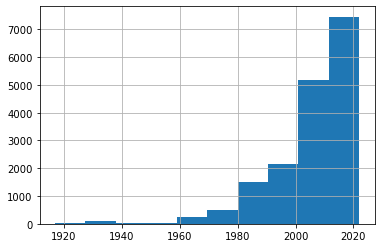

In [694]:
anime_df_no_syn[anime_df_no_syn['Year_Premiered']!='Unknown'].Year_Premiered.hist();

In [698]:
anime_df_no_syn[anime_df_no_syn['Genres'].str.contains('Hentai')]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Cleaned_Name,Year_Premiered,Duration_in_Minutes
165,188,Gosenzo San'e,6.11,"Comedy, Hentai, Mystery, Supernatural",Masquerade,御先祖賛江,OVA,4,"Sep 25, 1998 to Mar 25, 1999",Unknown,"AIC, Green Bunny, BEAM Entertainment",Unknown,Unknown,Original,"[30, min., per, ep.]",Rx - Hentai,Unknown,8469,2308,4,148,1072,100,122,866,51.0,42.0,89.0,168.0,159.0,132.0,59.0,19.0,20.0,33.0,Masquerade,1998,30.000000
180,203,Words Worth,6.75,"Adventure, Hentai, Demons, Magic, Fantasy",Unknown,ワーズ・ワース,OVA,5,"Aug 25, 1999 to Nov 25, 2000",Unknown,Green Bunny,NuTech Digital,Arms,Visual novel,"[30, min., per, ep.]",Rx - Hentai,Unknown,5518,7447,38,391,4406,264,265,2121,211.0,291.0,606.0,871.0,577.0,331.0,149.0,69.0,51.0,40.0,Words Worth,1999,30.000000
188,211,Pure Mail,6.26,Hentai,Unknown,ピュアメール,OVA,2,"Sep 25, 2001 to Dec 21, 2001",Unknown,"Pink Pineapple, Green Bunny",Adult Source Media,Unknown,Visual novel,"[30, min., per, ep.]",Rx - Hentai,Unknown,7731,3114,14,177,1834,112,122,869,64.0,71.0,165.0,268.0,310.0,175.0,86.0,43.0,25.0,26.0,Pure Mail,2001,30.000000
190,213,Pia Carrot e Youkoso!!,6.02,"Comedy, Romance, Hentai",Welcome to Pia Carrot,Piaキャロットへようこそ!!,OVA,3,"Oct 24, 1997 to Apr 24, 1998",Unknown,NuTech Digital,Unknown,Unknown,Unknown,"[29, min., per, ep.]",Rx - Hentai,Unknown,7767,3074,5,156,1715,106,139,958,50.0,48.0,114.0,240.0,281.0,196.0,89.0,54.0,18.0,30.0,Welcome to Pia Carrot,1997,29.000000
191,214,Pia Carrot e Youkoso!! 2,6.15,"Comedy, Romance, Hentai",Welcome To Pia Carrot 2,Piaキャロットへようこそ!! 2,OVA,3,"Oct 23, 1998 to Apr 23, 1999",Unknown,Pink Pineapple,Unknown,Unknown,Unknown,"[30, min., per, ep.]",Rx - Hentai,Unknown,8715,2097,4,99,1247,65,100,586,42.0,40.0,97.0,169.0,197.0,119.0,62.0,23.0,11.0,28.0,Welcome To Pia Carrot 2,1998,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17358,44192,Kimi ga Suki. The Animation,6.83,Hentai,Unknown,君が好き. THE ANIMATION,OVA,2,"Jan 29, 2021 to Mar 26, 2021",Unknown,Pink Pineapple,Unknown,Seven,Manga,[Unknown],Rx - Hentai,Unknown,8068,2745,16,1235,5,273,87,1145,85.0,78.0,139.0,221.0,165.0,71.0,26.0,22.0,11.0,16.0,Kimi ga Suki. The Animation,2021,28.504771
17359,44193,Ano Ko no Kawari ni Suki na Dake,5.91,Hentai,Unknown,実娘[あの子]の代わりに好きなだけ,OVA,2,"Dec 18, 2020 to ?",Unknown,Unknown,Unknown,Unknown,Manga,"[20, min., per, ep.]",Rx - Hentai,Unknown,10274,1097,4,605,5,175,69,243,41.0,13.0,37.0,81.0,97.0,55.0,39.0,21.0,9.0,12.0,Ano Ko no Kawari ni Suki na Dake,2020,20.000000
17360,44194,Haitoku no Kyoukai,6.18,Hentai,Unknown,背徳の境界,OVA,Unknown,"Jan 29, 2021 to ?",Unknown,Unknown,Unknown,Unknown,Original,[Unknown],Rx - Hentai,Unknown,10039,1226,3,520,5,174,66,461,22.0,17.0,36.0,80.0,79.0,48.0,18.0,11.0,10.0,6.0,Haitoku no Kyoukai,2021,28.504771
17366,44211,Rikujoubu Joshi wa Ore no Nama Onaho!!! The An...,Unknown,Hentai,Unknown,陸上部女子は俺の生オナホ!!! The Animation,OVA,2,"Feb 26, 2021 to Apr 30, 2021",Unknown,Unknown,Unknown,Unknown,Digital manga,"[20, min., per, ep.]",Rx - Hentai,Unknown,11168,755,5,122,0,52,21,560,6.0,3.0,5.0,11.0,16.0,8.0,9.0,3.0,1.0,1.0,Rikujoubu Joshi wa Ore no Nama Onaho!!! The An...,2021,20.000000


### Changing Duration to reflect minutes per episode

In [160]:
anime_df_no_syn['Duration'] = anime_df_no_syn['Duration'].str.split()

In [227]:
anime_df_no_syn['Duration_in_Minutes'] = [anime_df_no_syn['Duration'][x][0] if len(anime_df_no_syn['Duration'][x]) <= 1
                                         else (int(anime_df_no_syn['Duration'][x][0])/60 if anime_df_no_syn['Duration'][x][1] == 'sec.' 
                                         else (int(anime_df_no_syn['Duration'][x][0]) if anime_df_no_syn['Duration'][x][1] == 'min.'
                                         else ((int(anime_df_no_syn['Duration'][x][0])*60) + int(anime_df_no_syn['Duration'][x][2]) if anime_df_no_syn['Duration'][x][1] == 'hr.' and len(anime_df_no_syn['Duration'][x]) >= 4 and anime_df_no_syn['Duration'][x][2] != 'per'
                                         else (int(anime_df_no_syn['Duration'][x][0])*60 if anime_df_no_syn['Duration'][x][1] == 'hr.' and len(anime_df_no_syn['Duration'][x]) == 2      
                                         else anime_df_no_syn['Duration'][x][0])))) for x in range(len(anime_df_no_syn['Duration']))]






In [233]:
anime_df_no_syn[anime_df_no_syn['Duration_in_Minutes'].apply(lambda x: isinstance(x, str))].Duration_in_Minutes.unique()

array(['1', 'Unknown'], dtype=object)

In [235]:
anime_df_no_syn[anime_df_no_syn['Duration_in_Minutes']=='1'][['Duration', 'Duration_in_Minutes']]

,Duration,Duration_in_Minutes
1436,"[1, hr., per, ep.]",1
3178,"[1, hr., per, ep.]",1
5062,"[1, hr., per, ep.]",1
6358,"[1, hr., per, ep.]",1
9285,"[1, hr., per, ep.]",1


In [236]:
anime_df_no_syn['Duration_in_Minutes'].replace('1', 60, inplace=True)

In [237]:
anime_df_no_syn[anime_df_no_syn['Duration_in_Minutes'].apply(lambda x: isinstance(x, str))].Duration_in_Minutes.unique()

array(['Unknown'], dtype=object)

In [246]:
anime_df_no_syn['Duration_in_Minutes'].replace('Unknown', np.nan, inplace=True)

In [260]:
anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes

Type
Movie      53.253378
Music       3.346589
ONA         7.859471
OVA        28.504771
Special    18.572245
TV         19.547069
Unknown    23.000000
Name: Duration_in_Minutes, dtype: float64

In [299]:
anime_df_no_syn['Duration_in_Minutes'] = [anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Movie'] if anime_df_no_syn['Type'][x] =='Movie' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Music'] if anime_df_no_syn['Type'][x] =='Music' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['ONA'] if anime_df_no_syn['Type'][x] =='ONA' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['OVA'] if anime_df_no_syn['Type'][x] =='OVA' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Special'] if anime_df_no_syn['Type'][x] =='Special' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['TV'] if anime_df_no_syn['Type'][x] =='TV' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else (anime_df_no_syn.groupby('Type').mean().Duration_in_Minutes.loc['Unknown'] if anime_df_no_syn['Type'][x] =='Unknown' and pd.isna(anime_df_no_syn['Duration_in_Minutes'][x])== True
                                         else anime_df_no_syn['Duration_in_Minutes'][x])))))) for x in range(len(anime_df_no_syn['Duration_in_Minutes']))]



### Dropping superfluous columns

# Cleaning up user ratings

### EDA

In [307]:
anime_user_ratings = pd.read_csv('./Anime_data/animelist.csv')

In [308]:
anime_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109224747 entries, 0 to 109224746
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 4.1 GB


In [309]:
len(anime_user_ratings.user_id.unique())

325770

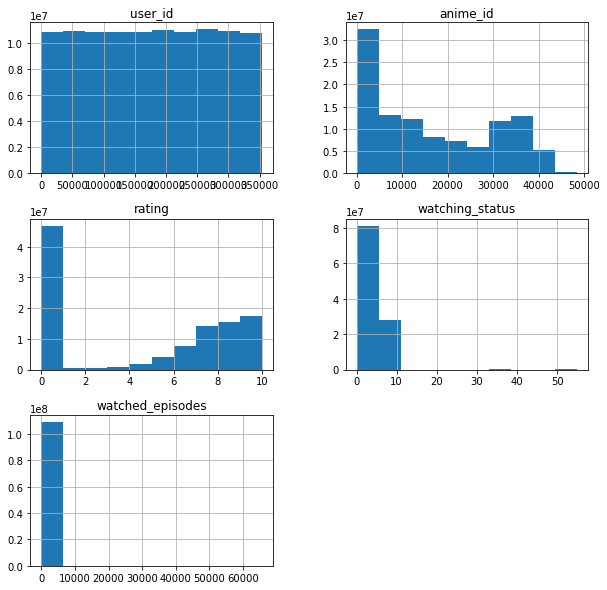

In [310]:
anime_user_ratings.hist(figsize=(10,10));

In [311]:
anime_user_ratings.describe()

,user_id,anime_id,rating,watching_status,watched_episodes
count,1.092247e+08,1.092247e+08,1.092247e+08,1.092247e+08,1.092247e+08
mean,1.768098e+05,1.649590e+04,4.245717e+00,3.087289e+00,1.210818e+01
std,1.018487e+05,1.379737e+04,3.912888e+00,1.774407e+00,1.463155e+02
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.849100e+04,3.194000e+03,0.000000e+00,2.000000e+00,0.000000e+00
50%,1.771420e+05,1.244500e+04,5.000000e+00,2.000000e+00,3.000000e+00
75%,2.651870e+05,3.083100e+04,8.000000e+00,6.000000e+00,1.200000e+01
max,3.534040e+05,4.849200e+04,1.000000e+01,5.500000e+01,6.553500e+04


In [312]:
anime_user_ratings.watching_status.unique()

array([ 1,  2,  3,  4,  6,  0,  5, 33, 55])

In [313]:
anime_user_ratings.rating.replace(0,np.nan, inplace=True)

In [314]:
anime_user_ratings.dropna(inplace=True)

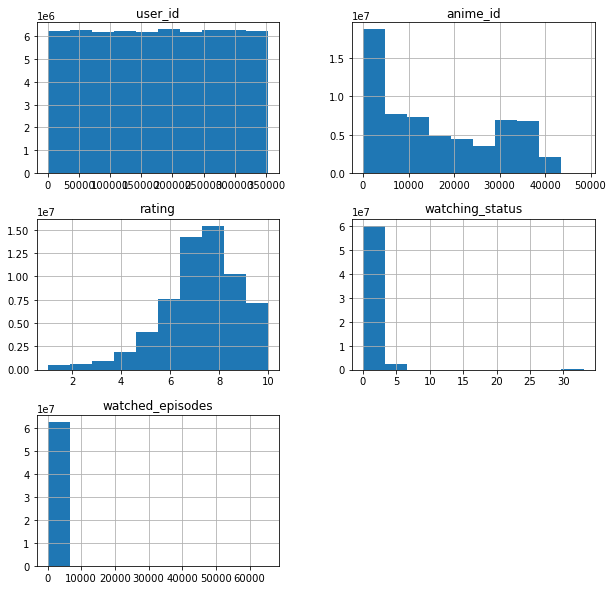

In [315]:
anime_user_ratings.hist(figsize=(10,10));

In [318]:
anime_user_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 62397712 entries, 0 to 109224745
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           int64  
 1   anime_id          int64  
 2   rating            float64
 3   watching_status   int64  
 4   watched_episodes  int64  
dtypes: float64(1), int64(4)
memory usage: 2.8 GB


### Checking Non-Normal values in watching_status column

In [316]:
anime_user_ratings.groupby('watching_status').size()

watching_status
0           77
1      1485402
2     57633278
3      1056358
4      1947440
5            1
6       275155
33           1
dtype: int64

In [317]:
anime_user_ratings[anime_user_ratings['watching_status'] == 0]

,user_id,anime_id,rating,watching_status,watched_episodes
2970882,10015,18767,7.0,0,2
2970886,10015,14741,10.0,0,12
2970889,10015,9479,10.0,0,13
2970892,10015,12549,7.0,0,12
2970893,10015,14893,6.0,0,1
...,...,...,...,...,...
36955269,120049,22043,10.0,0,12
36955270,120049,11061,10.0,0,15
36955271,120049,249,10.0,0,2
36955272,120049,1604,10.0,0,18


In [319]:
anime_user_ratings[(anime_user_ratings['watching_status'] == 0) & (anime_user_ratings['rating'] !=0)]



,user_id,anime_id,rating,watching_status,watched_episodes
2970882,10015,18767,7.0,0,2
2970886,10015,14741,10.0,0,12
2970889,10015,9479,10.0,0,13
2970892,10015,12549,7.0,0,12
2970893,10015,14893,6.0,0,1
...,...,...,...,...,...
36955269,120049,22043,10.0,0,12
36955270,120049,11061,10.0,0,15
36955271,120049,249,10.0,0,2
36955272,120049,1604,10.0,0,18


### Checking Non-Normal values in watched_episodes column

In [25]:
anime_user_ratings[anime_user_ratings['watched_episodes'] > 1800]

,user_id,anime_id,rating,watching_status,watched_episodes
186970,631,3221,6,2,9001
194983,656,21,7,1,36600
214838,722,3342,6,2,9001
355037,1125,355,5,2,9001
420236,1371,148,8,2,9001
...,...,...,...,...,...
109042337,352832,12393,0,2,1818
109042948,352832,2406,0,3,7000
109077329,352930,2406,9,1,6688
109104702,353021,149,7,2,9001


In [26]:
anime_df_no_syn[anime_df_no_syn['MAL_ID'] == 21]

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Cleaned_Name,Year_Premiered
11,21,One Piece,8.52,"Action, Adventure, Comedy, Super Power, Drama,...",One Piece,ONE PIECE,TV,Unknown,"Oct 20, 1999 to ?",Fall 1999,"Fuji TV, TAP, Shueisha","Funimation, 4Kids Entertainment",Toei Animation,Manga,24 min.,PG-13 - Teens 13 or older,95.0,31,1352724,126645,887333,33,187919,136245,141194,292445.0,166186.0,141755.0,85424.0,35342.0,19019.0,8201.0,3675.0,2616.0,6340.0,One Piece,1999


In [320]:
Top_1000_anime = anime_df_no_syn[anime_df_no_syn['Popularity'] != 0].sort_values('Popularity', ascending=True).head(1000)

In [321]:
len(Top_1000_anime.MAL_ID)

1000

In [322]:
anime_id_1000_anime = anime_user_ratings[anime_user_ratings.anime_id.isin(list(Top_1000_anime.MAL_ID))][['user_id', 'anime_id', 'rating']]



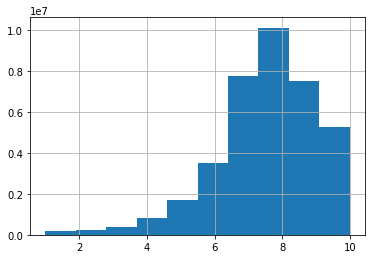

In [323]:
anime_id_1000_anime.rating.hist();

In [324]:
anime_id_1000_anime.groupby('user_id').size().sort_values()

user_id
126070      1
282722      1
282704      1
97146       1
97140       1
         ... 
291207    979
298783    983
321704    990
298988    990
283786    995
Length: 311353, dtype: int64

In [325]:
anime_id_1000_anime.replace(0,np.nan, inplace=True)

In [326]:
anime_id_1000_anime.dropna(inplace=True)

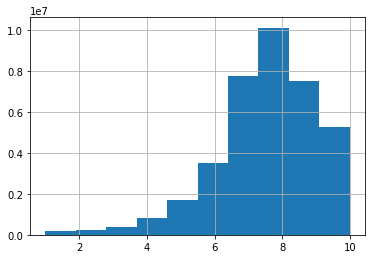

In [327]:
anime_id_1000_anime.rating.hist();

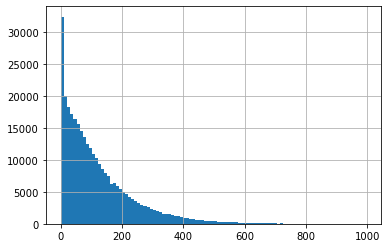

In [328]:
anime_id_1000_anime.groupby('user_id').size().sort_values().hist(bins=100);

In [329]:
anime_id_1000_anime.groupby('user_id').size().describe()

count    311352.000000
mean        120.374843
std         115.994606
min           1.000000
25%          35.000000
50%          87.000000
75%         171.000000
max         995.000000
dtype: float64

In [330]:
filtered_df_1000_anime = anime_id_1000_anime.groupby('user_id').filter(lambda x : len(x)>=5)
filtered_df_1000_anime = filtered_df_1000_anime.groupby('user_id').filter(lambda x : len(x)<=10)

In [331]:
filtered_df_1000_anime

,user_id,anime_id,rating
3407,15.0,223,10.0
3408,15.0,225,5.0
3445,15.0,72,7.0
3476,15.0,527,10.0
3488,15.0,482,7.0
...,...,...,...
109224715,353404.0,6033,10.0
109224716,353404.0,223,9.0
109224717,353404.0,225,8.0
109224723,353404.0,813,9.0


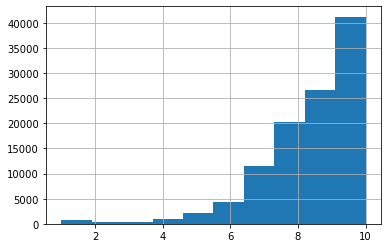

In [332]:
filtered_df_1000_anime.rating.hist();

In [333]:
len(filtered_df_1000_anime.user_id.unique())

14754

In [334]:
len(filtered_df_1000_anime.anime_id.unique())

997

# First Model

## Modeling with Surprise

In [101]:
reader = Reader(rating_scale=(1,10))
data = Dataset.load_from_df(filtered_df_1000_anime, reader)

In [102]:
train, test = train_test_split(data, test_size=.25)

In [103]:
svd_model = SVD()

In [105]:
%%time

svd_model.fit(train)
accuracy.rmse(svd_model.test(test))

RMSE: 1.4456
CPU times: user 212 ms, sys: 9.11 ms, total: 221 ms
Wall time: 229 ms


1.4456478327008737

In [135]:
params = {'n_factors': [50, 100, 200],
         'n_epochs': [20, 50, 100],
         'reg_all': [0.02, 0.001, 0.1]}
g_s_svd = GridSearchCV(SVD, param_grid=params, cv=3, n_jobs=-1, joblib_verbose=5)
g_s_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:  8.8min finished


In [136]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 1.4050497220655591, 'mae': 1.0215453579304936}
{'rmse': {'n_factors': 200, 'reg_all': 0.1, 'n_epochs': 100}, 'mae': {'n_factors': 50, 'reg_all': 0.1, 'n_epochs': 100}}


In [142]:
svdpp_model = SVDpp()

In [144]:
svdpp_model.fit(train)
accuracy.rmse(svdpp_model.test(test))

RMSE: 1.4430


1.4430259595887611

In [145]:
params = {'n_factors': [50, 100, 200],
         'n_epochs': [20, 50, 100],
         'reg_all': [0.02, 0.001, 0.1]}
g_s_svd = GridSearchCV(SVDpp, param_grid=params, cv=3, n_jobs=-1, joblib_verbose=5)
g_s_svd.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed: 33.9min
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed: 55.7min finished


In [146]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 1.4023020916229265, 'mae': 1.020563816833853}
{'rmse': {'n_factors': 200, 'n_epochs': 100, 'reg_all': 0.1}, 'mae': {'n_factors': 100, 'n_epochs': 100, 'reg_all': 0.1}}


Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6592
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6591
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6590
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6589


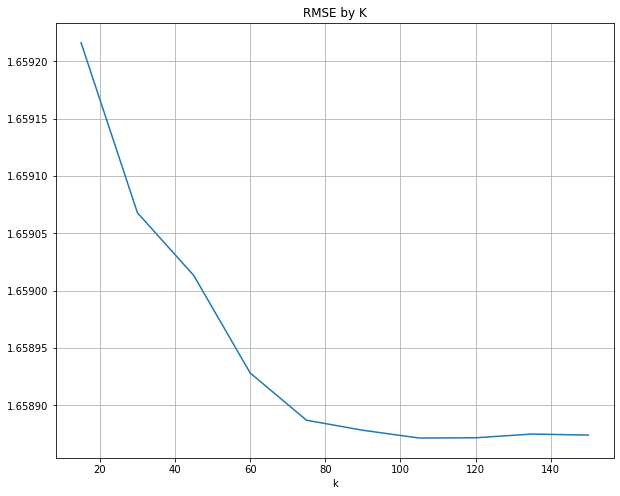

In [108]:
knn_basic_rmse_list = []

# Calculate RMSE for different K
for k in range(15, 160, 15):
    knn_basic = KNNBasic(k=k, sim_options={'name':'pearson', 'user_based':True})
    knn_basic.fit(train)
    knn_basic_rmse_list.append(accuracy.rmse(knn_basic.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_basic_rmse_list)
ax.grid(True)

In [ ]:
knn_basic = KNNBasic(k=75, sim_options={'name':'pearson', 'user_based':True})
cv_knn_basic = cross_validate(knn_basic, data, n_jobs=-1, verbose=True)

In [110]:
np.mean(cv_knn_basic['test_rmse'])

1.6564984468355402

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.6292


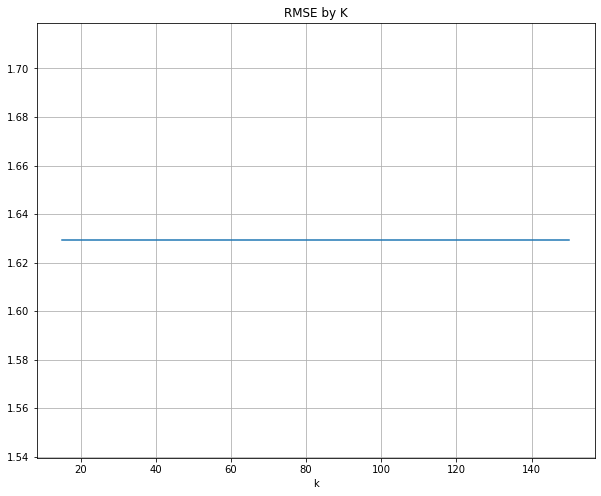

In [112]:
knn_basic_item_rmse_list = []

# Calculate RMSE for different K
for k in range(15, 160, 15):
    knn_basic = KNNBasic(k=k, sim_options={'name':'pearson', 'user_based':False})
    knn_basic.fit(train)
    knn_basic_item_rmse_list.append(accuracy.rmse(knn_basic.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_basic_item_rmse_list)
ax.grid(True)

In [113]:
knn_item_basic = KNNBasic(k=45, sim_options={'name':'pearson', 'user_based':False})
cv_knn_item_basic = cross_validate(knn_item_basic, data, n_jobs=-1, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5949  1.6013  1.6196  1.5997  1.6003  1.6032  0.0085  
MAE (testset)     1.0826  1.0863  1.0964  1.0856  1.0885  1.0879  0.0046  
Fit time          0.34    0.32    0.31    0.33    0.32    0.32    0.01    
Test time         0.52    0.52    0.57    0.57    0.32    0.50    0.09    


In [114]:
np.mean(cv_knn_item_basic['test_rmse'])

1.6031590888381362

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5328
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5327
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5327
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5326
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5325
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5325
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5325
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5325
Estimating biases using als...
C

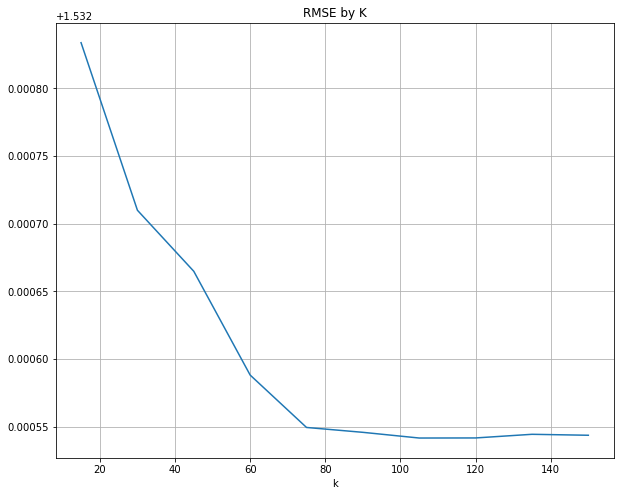

In [115]:
knn_baseline_rmse_list = []

# Calculate SSE for different K
for k in range(15, 160, 15):
    knn_baseline = KNNBaseline(k=k, sim_options={'name':'pearson', 'user_based':True})
    knn_baseline.fit(train)
    knn_baseline_rmse_list.append(accuracy.rmse(knn_baseline.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_baseline_rmse_list)
ax.grid(True)

In [121]:
knn_baseline = KNNBaseline(k=75, sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline, data, n_jobs=-1, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5526  1.5333  1.5083  1.5060  1.5289  1.5258  0.0172  
MAE (testset)     1.1366  1.1235  1.1165  1.1152  1.1282  1.1240  0.0079  
Fit time          256.68  252.16  253.64  257.13  64.22   216.77  76.30   
Test time         11.96   13.62   12.03   11.86   5.24    10.94   2.92    


In [122]:
np.mean(cv_knn_baseline['test_rmse'])

1.5258146718519003

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5410
Estimating biases using als...
C

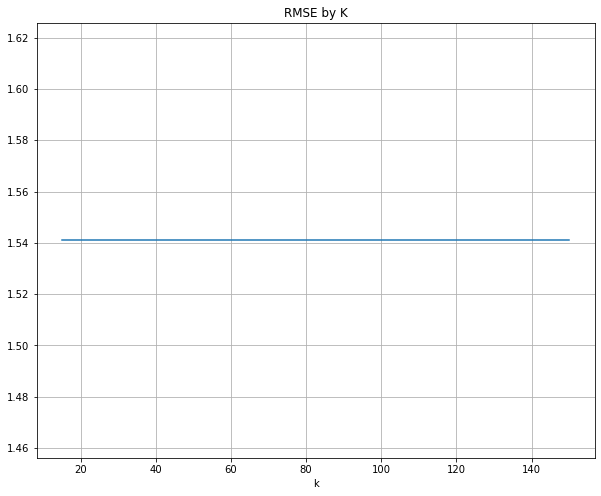

In [118]:
knn_baseline_item_rmse_list = []

# Calculate SSE for different K
for k in range(15, 160, 15):
    knn_baseline = KNNBaseline(k=k, sim_options={'name':'pearson', 'user_based':False})
    knn_baseline.fit(train)
    knn_baseline_item_rmse_list.append(accuracy.rmse(knn_baseline.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_baseline_item_rmse_list)
ax.grid(True)

In [119]:
knn_item_baseline = KNNBaseline(k=60, sim_options={'name':'pearson', 'user_based':False})
cv_knn_item_baseline = cross_validate(knn_item_baseline, data, n_jobs=-1, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5147  1.4976  1.5228  1.5048  1.5289  1.5138  0.0114  
MAE (testset)     1.0382  1.0385  1.0455  1.0360  1.0466  1.0410  0.0043  
Fit time          0.34    0.39    0.47    0.44    0.42    0.41    0.04    
Test time         0.59    0.61    0.56    0.53    0.34    0.52    0.10    


In [120]:
np.mean(cv_knn_item_baseline['test_rmse'])

1.513750487255257

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5658
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5655
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 1.5656


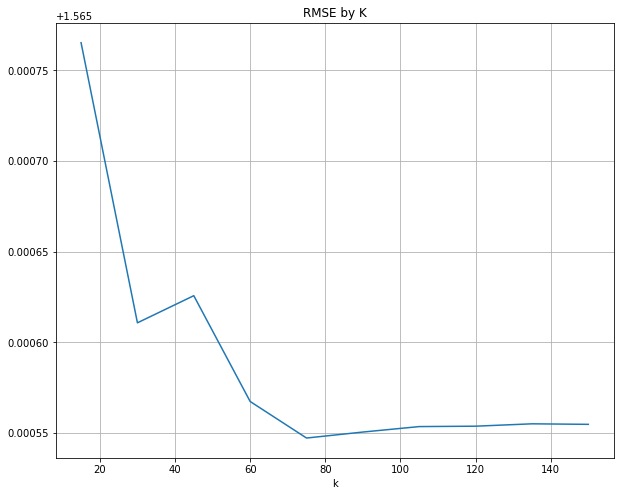

In [147]:
knn_means_rmse_list = []

# Calculate RMSE for different K
for k in range(15, 160, 15):
    knn_means = KNNWithMeans(k=k, sim_options={'name':'pearson', 'user_based':True})
    knn_means.fit(train)
    knn_means_rmse_list.append(accuracy.rmse(knn_means.test(test)))

# Plot values of RMSE
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('RMSE by K')
ax.set_xlabel('k')
ax.plot(range(15, 160, 15), knn_means_rmse_list)
ax.grid(True)

In [148]:
knn_item_baseline = KNNBaseline(k=75, sim_options={'name':'pearson', 'user_based':False})
cv_knn_item_baseline = cross_validate(knn_item_baseline, data, n_jobs=-1, verbose=True)

Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.5251  1.5142  1.5176  1.4978  1.5203  1.5150  0.0093  
MAE (testset)     1.0510  1.0393  1.0395  1.0305  1.0414  1.0403  0.0065  
Fit time          0.46    0.45    0.45    0.43    0.26    0.41    0.08    
Test time         0.60    0.58    0.59    0.59    0.31    0.53    0.11    


In [149]:
np.mean(cv_knn_item_baseline['test_rmse'])

1.5150031184137878

In [371]:
def Anime_rater(Top_1000_anime, num, genre=None):
    userID = 300000000
    rating_list = []
    while num > 0:
        if genre:
            anime = Top_1000_anime[Top_1000_anime['Genres'].str.contains(genre)].sample(1)
        else:
            anime = Top_1000_anime.sample(1)
        print(anime[['Cleaned_Name','Year_Premiered','Type']])
        rating = input('How do you rate this anime on a scale of 1-10, press n if you have not seen :\n')
        if rating not in str(list(range(1,11))):
            continue
        else:
            rating_one_anime = {'user_id':userID,'anime_id':anime['MAL_ID'].values[0],'rating':rating}
            rating_list.append(rating_one_anime) 
            num -= 1
    return rating_list    

In [372]:
user_rating = Anime_rater(Top_1000_anime, 6)

                        Cleaned_Name Year_Premiered Type
7453  Devil Survivor 2 The Animation           2013   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
10
                  Cleaned_Name Year_Premiered Type
8559  MUSHI-SHI -Next Passage-           2014   TV
How do you rate this anime on a scale of 1-10, press n if you have not seen :
10
                                           Cleaned_Name Year_Premiered   Type
6116  Berserk:The Golden Age Arc I - The Egg of the ...           2012  Movie
How do you rate this anime on a scale of 1-10, press n if you have not seen :
10
                                           Cleaned_Name Year_Premiered   Type
15680  Boku no Hero Academia the Movie 2: Heroes:Rising           2019  Movie
How do you rate this anime on a scale of 1-10, press n if you have not seen :
10
      Cleaned_Name Year_Premiered Type
11037         GATE           2016   TV
How do you rate this anime on a scale of 1-10, press n if you have not

In [373]:
user_rating

[{'user_id': 300000000, 'anime_id': 16512, 'rating': '10'},
 {'user_id': 300000000, 'anime_id': 21939, 'rating': '10'},
 {'user_id': 300000000, 'anime_id': 10218, 'rating': '10'},
 {'user_id': 300000000, 'anime_id': 39565, 'rating': '10'},
 {'user_id': 300000000, 'anime_id': 31637, 'rating': '10'},
 {'user_id': 300000000, 'anime_id': 36649, 'rating': '10'}]

In [374]:
new_ratings_df = filtered_df_1000_anime.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings_df, reader)

In [375]:
svd_ = SVD(n_factors=200, reg_all=0.1, n_epochs=100)
svd_.fit(new_data.build_full_trainset())

In [376]:
list_of_anime = []
for m_id in filtered_df_1000_anime['anime_id'].unique():
    list_of_anime.append((m_id,svd_.predict(3000000000,m_id)[3]))

In [377]:
ranked_anime = sorted(list_of_anime, key=lambda x:x[1], reverse=True)

In [378]:
def recommended_anime(user_ratings, anime_title_df, n):
        for idx, rec in enumerate(user_ratings):
            title = anime_title_df.loc[anime_title_df['MAL_ID'] == int(rec[0])]['Cleaned_Name']
            print('Recommendation # ', idx+1, ': ', title, '\n')
            n-= 1
            if n == 0:
                break
            
recommended_anime(ranked_anime, Top_1000_anime, 5)

Recommendation #  1 :  6006    Gintama Season 2
Name: Cleaned_Name, dtype: object 

Recommendation #  2 :  12242    Gintama Season 5
Name: Cleaned_Name, dtype: object 

Recommendation #  3 :  4690    Redline
Name: Cleaned_Name, dtype: object 

Recommendation #  4 :  4018    the Garden of sinners Chapter 7:Murder Specula...
Name: Cleaned_Name, dtype: object 

Recommendation #  5 :  13769    Banana Fish
Name: Cleaned_Name, dtype: object 



In [633]:
ranked_anime[1][0]

34096

In [381]:
def Anime_Recommender(user_ratings, anime_df, num, rec_num, genre=None):
    userID = 300000000
    rating_list = []
    while num > 0:
        if genre:
            anime = anime_df[anime_df['Genres'].str.contains(genre)].sample(1)
        else:
            anime = anime_df.sample(1)
        print(anime[['Cleaned_Name','Year_Premiered','Type']])
        rating = input('How do you rate this anime on a scale of 1-10, press n if you have not seen :\n')
        if rating not in str(list(range(1,11))):
            clear_output(wait=True)
            continue
        else:
            rating_one_anime = {'user_id':userID,'anime_id':anime['MAL_ID'].values[0],'rating':rating}
            rating_list.append(rating_one_anime)
            clear_output(wait=True)
            num -= 1
    new_ratings_df = user_ratings.append(rating_list, ignore_index=True) 
    reader_rec = Reader(rating_scale=(1,10))
    new_data = Dataset.load_from_df(new_ratings_df, reader_rec)
    svd_ = SVD(n_factors=200, reg_all=0.1, n_epochs=100)
    svd_.fit(new_data.build_full_trainset())
    list_of_anime = []
    for a_id in user_ratings['anime_id'].unique():
        list_of_anime.append((a_id, svd_.predict(3000000000, a_id)[3]))
    ranked_anime = sorted(list_of_anime, key=lambda x:x[1], reverse=True)
    for idx, rec in enumerate(ranked_anime):
        title = anime_df.loc[anime_df['MAL_ID'] == int(rec[0])]['Cleaned_Name']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        rec_num -= 1
        if rec_num == 0:
            break

In [380]:
%%time
Anime_Recommender(filtered_df_1000_anime, Top_1000_anime, 5, 5)

Recommendation #  1 :  6006    Gintama Season 2
Name: Cleaned_Name, dtype: object 

Recommendation #  2 :  4690    Redline
Name: Cleaned_Name, dtype: object 

Recommendation #  3 :  12242    Gintama Season 5
Name: Cleaned_Name, dtype: object 

Recommendation #  4 :  13769    Banana Fish
Name: Cleaned_Name, dtype: object 

Recommendation #  5 :  9343    Fate/stay night:Heaven's Feel - I. Presage Flower
Name: Cleaned_Name, dtype: object 

CPU times: user 48.8 s, sys: 674 ms, total: 49.5 s
Wall time: 2min 23s


In [716]:
def Anime_Recommender_2(user_ratings, anime_df, rating_num, rec_num, new_user=True, genre=None, show_type=None):
    user_entry = 1
    while user_entry > 0:
        if new_user == False:
            userID = int(input('Please enter User ID (Numerical values only)'))
            if userID not in list(user_ratings['user_id']) or userID == '':
                print('User ID not in system')
                continue
            else:
                print('Welcome Back')
                user_entry -= 1
        else:
            userID = filtered_df_1000_anime['user_id'].max() + 1
            print('Welcome')
            print('Your User ID is: ',userID)
            user_entry -= 1
    rating_list = pd.DataFrame()
    if new_user == False:
        rating_list = rating_list.append(user_ratings[user_ratings['user_id'] == userID], ignore_index=True)
    else:
        rating_list = rating_list
    while rating_num > 0:
        anime = anime_df.sample(1)
        print(anime[['Cleaned_Name','Year_Premiered','Type']])
        rating = input('How do you rate this anime on a scale of 1-10, press n if you have not seen :\n')
        if rating == 'n':
            clear_output(wait=True)
            continue
        elif rating not in str(list(range(1,11))) or rating == '':           
            clear_output(wait=True)
            print('Not a valid entry')
            continue
        else:
            rating_one_anime = {'user_id':userID,'anime_id':anime['MAL_ID'].values[0],'rating':rating}
            rating_list = rating_list.append(rating_one_anime, ignore_index=True)
            rating_list = rating_list[['user_id','anime_id','rating']]
            clear_output(wait=True)
            rating_num -= 1
    new_ratings_df = user_ratings.append(rating_list, ignore_index=True) 
    reader_rec = Reader(rating_scale=(1,10))
    new_data = Dataset.load_from_df(new_ratings_df, reader_rec)
    svd_ = SVD(n_factors=200, reg_all=0.1, n_epochs=100)
    svd_.fit(new_data.build_full_trainset())
    list_of_anime = []
    for a_id in user_ratings['anime_id'].unique():
        list_of_anime.append((a_id, svd_.predict(userID, a_id)[3]))
    ranked_anime = sorted(list_of_anime, key=lambda x:x[1], reverse=True)
    new_ranked_anime = []
    for x in ranked_anime:
        if x[0] in list(rating_list['anime_id']):
            continue
        else:
            new_ranked_anime.append(x)
    if genre:
        new_list = []
        genre_list = list(anime_df[anime_df['Genres'].str.contains(genre)]['MAL_ID'])
        for x in new_ranked_anime:
            if x[0] in genre_list:
                new_list.append(x)
            else:
                continue
        new_ranked_anime = new_list
    else:
        pass
    if show_type:
        new_list = []
        type_list = list(anime_df[anime_df['Type'].str.contains(show_type)]['MAL_ID'])
        for x in new_ranked_anime:
            if x[0] in type_list:
                new_list.append(x)
            else:
                continue
        new_ranked_anime = new_list
    else:
        pass
    if len(new_ranked_anime) == 0:
        return print('Unfortunately, no results fit your criteria')  
    elif len(new_ranked_anime) < rec_num:
        rec_num = len(new_ranked_anime)
        print('Sorry, These are all our results')   
    else:
        pass
    for idx, rec in enumerate(new_ranked_anime):
        title = anime_df.loc[anime_df['MAL_ID'] == int(rec[0])]['Cleaned_Name']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        rec_num -= 1
        if rec_num == 0:
            break
            

In [718]:
Anime_Recommender_2(filtered_df_1000_anime, Top_1000_anime, 5, 5)

Unfortunately, no results fit your criteria


In [714]:
Top_1000_anime[Top_1000_anime['Cleaned_Name']=='K-ON! The Movie']

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,Producers,Licensors,Studios,Source,Duration,Rating,Ranked,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,Cleaned_Name,Year_Premiered,Duration_in_Minutes
5846,9617,K-On! Movie,8.33,"Music, Slice of Life, Comedy",K-ON! The Movie,映画 けいおん！,Movie,1,"Dec 3, 2011",Unknown,"Pony Canyon, Animation Do",Sentai Filmworks,Kyoto Animation,4-koma manga,"[1, hr., 50, min.]",PG-13 - Teens 13 or older,202.0,607,238850,2091,3372,183015,1561,824,50078,29490.0,36866.0,41053.0,21891.0,6997.0,2415.0,656.0,293.0,200.0,445.0,K-ON! The Movie,2011,110.0
